# dcd_ch4_hw

## Homework for Chapter 4

In [26]:
#from math import exp
import matplotlib.pyplot as plt
import numpy as np
from PSP_heat import *
from PSP_thermalCond import *
from PSP_soil import *
from math import *

In [46]:
bulkDensity=1300
waterContent=range(10,50,10)
clay=.4
temperature = range(-20,40,2)
K_therm = []
xpoints =[]
theta_points = []
for y in waterContent:
    for x in temperature:
        K= thermalConductivity(bulkDensity, y/100 , clay, x)
        xpoints.append(x)
        K_therm.append(K)

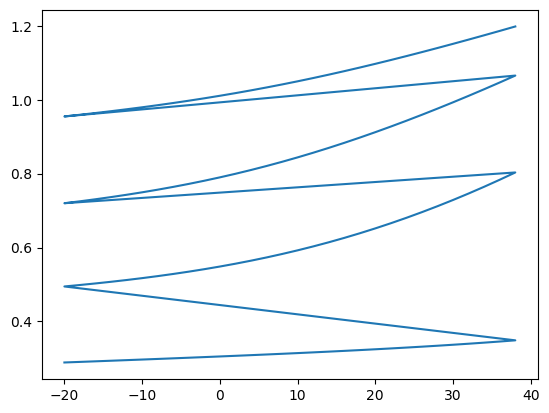

In [49]:
plt.plot(xpoints,K_therm)